<a href="https://colab.research.google.com/github/fahaerte/LSIES-FinalAssignment/blob/main/LSIES_FinalAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set parameters according to execution envirionment:


*   drive --> True if Notebook is executed in the Colab environment
*   install_packages --> Set True if needed
*   In case you are using the colab environment: Specify your path to the helper_func files





In [20]:
drive = True
install_packages = False

In [21]:
if install_packages:
  !pip install Basemap basemap-data-hires
  !pip install pandas matplotlib numpy
  !pip install sklearn
  !pip install datetime

In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from csv import reader
from sklearn.metrics import r2_score
from datetime import datetime
from datetime import timedelta as tdelta
from datetime import time as time
import warnings
from mpl_toolkits.basemap import Basemap

if drive:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/Colab\ Notebooks/LSIES

from helpe_funcs import *

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/LSIES


Set some parameters

In [23]:
if drive:
  dir_path = '/content/drive/MyDrive/data/'
else :
  dir_path = './data/'

folders = ['region_1_mustamäe_kristiine', 'region_2_data_kesklinn', 'region_3_kadriorg_lasnamäe', 'region_4_ülemiste']
start_time = datetime.strptime('2022.08.01 00:00:00', '%Y.%m.%d %H:%M:%S')
end_time = datetime.strptime('2022.08.13 23:59:00', '%Y.%m.%d %H:%M:%S')
csv_file_name_sensor_positions = 'sensor_positions.csv'
columns_sensors_positions = ['sensor_name', 'latitude', 'longitude', 'region']

**Task 1: Plot locations of sensors**


In [24]:
sensor_positions_df = pd.DataFrame(columns=columns_sensors_positions, index=[0])

with open(dir_path + csv_file_name_sensor_positions, 'r') as read_obj:
    csv_reader = reader(read_obj)
    for row in csv_reader:
        data = {columns_sensors_positions[0]: row[1], columns_sensors_positions[1]: float(row[0].split(' ')[0].replace('(', '')), columns_sensors_positions[2]: float(row[0].split(' ')[1].replace(')', '')), columns_sensors_positions[3] : ''}
        data_df = pd.DataFrame(data, columns=columns_sensors_positions, index=[0])
        sensor_positions_df = pd.concat([sensor_positions_df, data_df])

sensor_positions_df = sensor_positions_df.dropna()

for folder in folders:
    for file in os.listdir(dir_path + folder):
        sensor_name = file.split('-')[0]
        region = int(folder.split('_')[1])
        sensor_positions_df.loc[sensor_positions_df.sensor_name==sensor_name, 'region'] = region

In [25]:
print(sensor_positions_df.head())

  sensor_name   latitude  longitude region
0        2004  24.726405  59.398497      1
0        2013  24.748805  59.434405      2
0        2015  24.751089  59.434361      2
0        2018  24.726473  59.396803      1
0        201A  24.744596  59.441991      2


In [26]:
def plot_sensor_positions(df, all_regions):

    tallinn_map = plt.imread(dir_path + '/map.png')

    image_width = tallinn_map.shape[1] / 100 * 2
    image_height = tallinn_map.shape[0] / 100 * 2

    lon_min = df['longitude'].min()
    lon_max = df['longitude'].max()
    lat_min = df['latitude'].min()
    lat_max = df['latitude'].max()

    colors = ['red', 'blue', 'green', 'black']

    fig, ax = plt.subplots(figsize=(image_width, image_height))

    # Create basemap with specified boundaries
    m = Basemap(projection='merc', resolution='h',
                llcrnrlon=lat_min, llcrnrlat=lon_min,
                urcrnrlon=lat_max, urcrnrlat=lon_max)
    m.imshow(tallinn_map, interpolation='lanczos', origin='upper')

    # Plot sensor locations
    for i, r in enumerate(all_regions):
        x, y = m(df[df['region'] == r]['latitude'].values, df[df['region'] == r]['longitude'].values)
        m.scatter(x, y, c=colors[i], marker='o', s=10)

    ax.set_xlabel('latitude')
    ax.set_ylabel('longitude')

    legend = ["Region " + str(r) for r in all_regions]
    ax.legend(legend)

    plt.show()

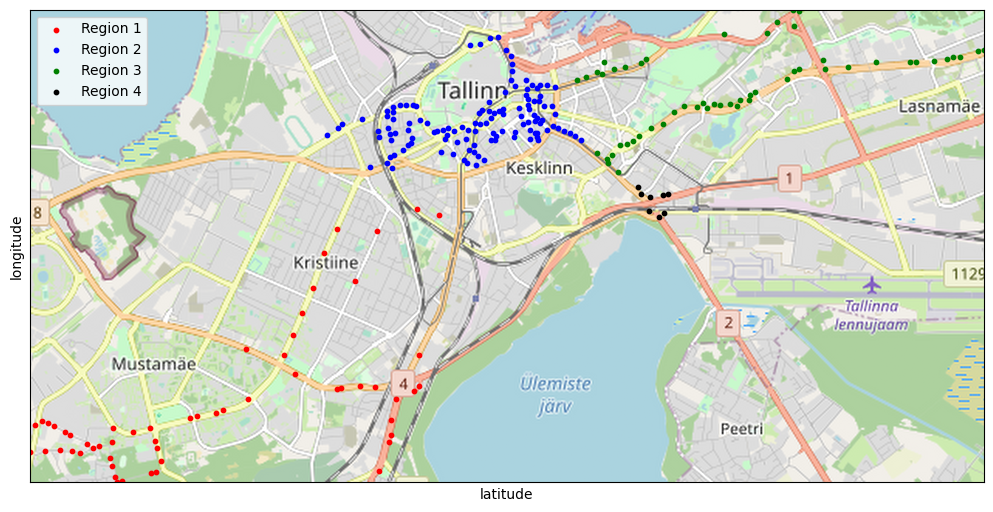

In [27]:
regions = sensor_positions_df['region'].sort_values().unique()

plot_sensor_positions(sensor_positions_df, regions)

Number of sensors per region:


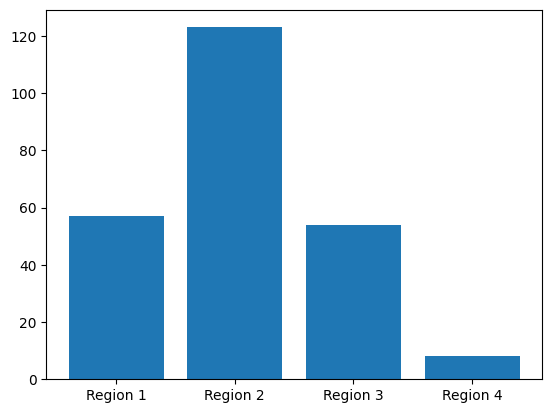

In [28]:
print('Number of sensors per region:')
amount_sensors_per_region = sensor_positions_df.groupby('region')['sensor_name'].count()
regions_strings = ["Region " + str(r) for r in regions]
plt.bar(regions_strings, amount_sensors_per_region)
plt.show()

**Task 2: Interpolation**

Form groups based on distance between stations

In [34]:
print(sensor_positions_df.head())

  sensor_name   latitude  longitude region
0        2004  24.726405  59.398497      1
0        2013  24.748805  59.434405      2
0        2015  24.751089  59.434361      2
0        2018  24.726473  59.396803      1
0        201A  24.744596  59.441991      2


In [33]:
sensor_ids = list(sensor_positions_df['sensor_name'])
groups = make_groups(sensor_ids, sensor_positions_df)
sensor_positions_df.insert(loc=1, column='grps', value=groups['grp'])

create groups of sensors based on distance between them


KeyError: ignored

Import sound pressure values

In [30]:
list_df = []
sensor_names = []
region_list = []
df_counter = 0

for folder in folders:
    for file in os.listdir(dir_path + folder):
        sensor_name = file.split('-')[0]
        region_list.append(int(folder.split('_')[1]))
        sensor_names.append(file.split('-')[0])
        df = pd.read_csv(dir_path + folder + "/" + file, index_col=None, header=0)
        df['Time'] = df.apply(lambda row: datetime.strptime(row['Time'], '%Y-%m-%d %H:%M:%S'), axis=1)
        df.rename(columns={'dt_sound_level_dB': sensor_name}, inplace=True)
        list_df.append(df)


for df in list_df:
    df = df[df.Time >= start_time]
    df = df[df.Time <= end_time]

    start_row = pd.DataFrame({'Time': start_time, 'dt_sound_level_dB': df.iloc[0][sensor_names[df_counter]]}, index=[0])
    start_row['Time'] = pd.to_datetime(start_row['Time'])

    end_row = pd.DataFrame({'Time': end_time, sensor_names[df_counter]: df.iloc[-1][sensor_names[df_counter]]}, index=[0])
    end_row['Time'] = pd.to_datetime(end_row['Time'])

    df['Time'] = pd.to_datetime(df['Time'])
    df = df.set_index('Time')

    if not (df.index == end_time).any():
        df.loc[end_time] = [df.iloc[-1][sensor_names[df_counter]]]

    if not (df.index == start_time).any():
        df.loc[start_time] = [df.iloc[0][sensor_names[df_counter]]]

    df = df.sort_values(by='Time')
    df_counter += 1

<ipython-input-30-1c786b7cda5c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time'] = pd.to_datetime(df['Time'])
<ipython-input-30-1c786b7cda5c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time'] = pd.to_datetime(df['Time'])
<ipython-input-30-1c786b7cda5c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [31]:
import datetime as datetime2

dt = start_time
step = datetime2.timedelta(minutes=1)
result = []

while dt < end_time:
    result.append(dt.strftime('%Y.%m.%d %H:%M:%S'))
    dt += step

col = {'Time': result, 'dummy': 0}
df_all_timestamps = pd.DataFrame(data=col)
df_all_timestamps['Time'] = pd.to_datetime(df_all_timestamps['Time'])
df_all_timestamps = df_all_timestamps.set_index('Time')

# print(df_all_timestamps.head())

del df_counter, dt